In [62]:
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
#import shutil
import os
#import random
try:
 from PIL import Image
except ImportError:
 import Image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [63]:
%cd /content/

/content


In [64]:
def detect_lp(model, I, max_dim, lp_threshold):
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor

In [65]:
import cv2
import numpy as np
#import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
#import glob
from google.colab.patches import cv2_imshow

In [66]:

def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [67]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [68]:
def preprocess_image(img,resize=False):
    #img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

In [69]:
def get_plate(img, Dmax=608, Dmin=256):
    vehicle = preprocess_image(img)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

In [78]:
def image_for_ocr(LpImg):
    if (len(LpImg)): #check if there is at least one license image
        # Scales, calculates absolute values, and converts the result to 8-bit.
        plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
        #cv2_imshow(plate_image)
        
        # convert to grayscale and blur the image
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)
        
        # Applied inversed thresh_binary 
        binary = cv2.threshold(blur, 180, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        binary= cv2.bitwise_not(binary)
        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    return([plate_image,gray,blur,binary,kernel3,thre_mor])

In [80]:
def find_num(img):
    #img = cv2.imread(path)
    try:
        vehicle, LpImg,cor = get_plate(img)
    except AssertionError:
        pass
    ocr_image=image_for_ocr(LpImg)[0]
    number= pytesseract.image_to_string(ocr_image,lang="eng")
    s=[]
    for i in number:
        if i.isalnum():
            s.append(i)
    return("".join(s))


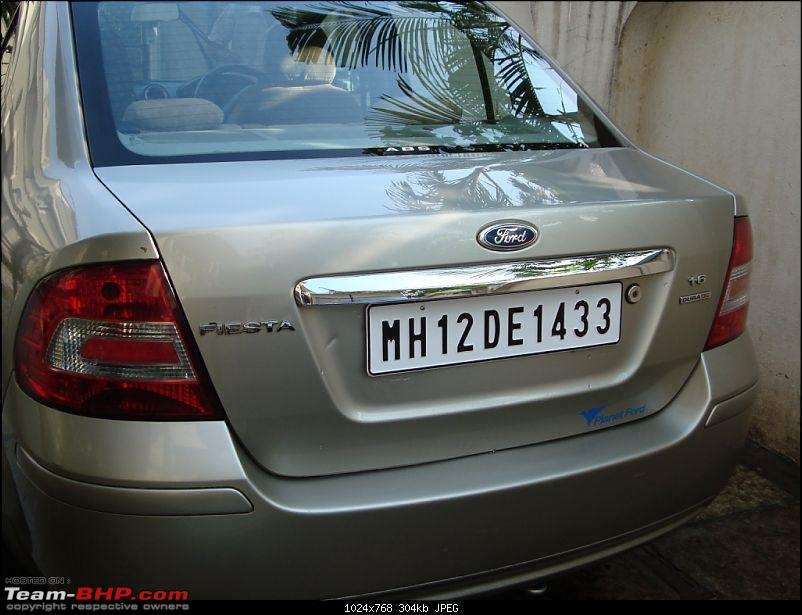

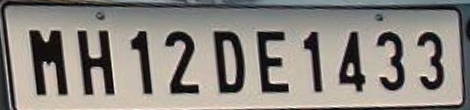

MH12DE1433


In [81]:
path = cv2.imread("/content/india_car_plate.jpg")
cv2_imshow(path)
print(find_num(path))

In [74]:
video_capture = cv2.VideoCapture()#path to video
while True:
    _,frame = video_capture.read()
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    find_num(gray)